## Early Predictor for Student Success Based on Behavioural and Demographical Indicators

Import libraries

In [4]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.display import display

import warnings
warnings.filterwarnings('ignore')

Load data

In [11]:
zf = zipfile.ZipFile('./data.zip')
student_info = pd.read_csv(zf.open('studentInfo.csv'))
student_vle = pd.read_csv(zf.open('studentVle.csv'))
student_assessment = pd.read_csv(zf.open('studentAssessment.csv'))
student_registration = pd.read_csv(zf.open('studentRegistration.csv'))
assessments = pd.read_csv(zf.open('assessments.csv'))

Basic information about modules, first assessments and number of registered students

In [12]:
# Get information about first day assessments
basic_info = assessments.filter(items=['code_module', 'code_presentation', 'date'])
basic_info = basic_info.groupby(['code_module', 'code_presentation']).min()
basic_info = pd.merge(basic_info, assessments, on=['code_module', 'code_presentation', 'date'],
                             how='inner').filter(items=['code_module', 'code_presentation', 'id_assessment', 'date'])

# Get total number of registered students for each module
registrations = student_registration.filter(items=['code_module', 'code_presentation', 'id_student']).groupby(
    ['code_module', 'code_presentation']).count().reset_index()
basic_info.insert(4, "number of registered students", registrations['id_student'])
basic_info

,code_module,code_presentation,id_assessment,date,number of registered students
0,AAA,2013J,1752,19.0,383
1,AAA,2014J,1758,19.0,365
2,BBB,2013B,14984,19.0,1767
3,BBB,2013J,14996,19.0,2237
4,BBB,2014B,15008,12.0,1613
5,BBB,2014J,15020,19.0,2292
6,CCC,2014B,24286,18.0,1936
7,CCC,2014J,24295,18.0,2498
8,DDD,2013B,25341,23.0,1303
9,DDD,2013J,25348,25.0,1938


### Data preparation

In [13]:
clicks_before_start = student_vle[student_vle['date'] < 0]

# Merge student_info and student_registration tables to get registration_date
df1 = pd.merge(student_info, student_registration, how='left', on=['id_student', 'code_module', 'code_presentation'])

# Merge previous table with basic_info that was created earlier to get first assessment days and ids
df2 = pd.merge(df1, basic_info, on=['code_module', 'code_presentation'], how='left')

# Merge previous table with student assessment to find student's scores on their first assessments
df3 = pd.merge(df2, student_assessment, on=['id_assessment', 'id_student'], how='left')

# Merge previous table with clicks_before_start table that was created earlier
data = pd.merge(df3, clicks_before_start, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Keep only columns that are needed later
data = data.filter(['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'sum_click',
                    'date_registration', 'age_band',
                    'disability', 'gender', 'num_of_prev_attempts', 'final_result'])
data.fillna(value=0, inplace=True)

# Get number of clicks before course start
data = data.groupby(
    ['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'date_registration',
     'age_band', 'disability', 'gender', 'num_of_prev_attempts', 'final_result']).sum().reset_index()

# Get the final dataframe that will be used
data.rename(columns={'score': 'first_assignment', 'sum_click': 'clicks_before_start',
                     'num_of_prev_attempts': 'previous_attempts', 'age_band': 'age'}, inplace=True)
data.head()

,code_module,code_presentation,id_student,first_assignment,highest_education,date_registration,age,disability,gender,previous_attempts,final_result,clicks_before_start
0,AAA,2013J,11391,78.0,HE Qualification,-159.0,55<=,N,M,0,Pass,98.0
1,AAA,2013J,28400,70.0,HE Qualification,-53.0,35-55,N,F,0,Pass,215.0
2,AAA,2013J,30268,0.0,A Level or Equivalent,-92.0,35-55,Y,F,0,Withdrawn,102.0
3,AAA,2013J,31604,72.0,A Level or Equivalent,-52.0,35-55,N,F,0,Pass,169.0
4,AAA,2013J,32885,69.0,Lower Than A Level,-176.0,0-35,N,F,0,Pass,295.0


Converting all categorical variables into dichotomous variables.

In [14]:
education_mapping = {
    'No Formal quals': 0,
    'Lower Than A Level': 0,
    'A Level or Equivalent': 0,
    'HE Qualification': 1,
    'Post Graduate Qualification': 1
}

age_mapping = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 1
}

grade_mapping = {
    'Withdrawn': -1,
    'Fail': -1,
    'Pass': 1,
    'Distinction': 1
}

gender_mapping = {
    'F': 1,
    'M': 0
}

disability_mapping = {
    'N': 0,
    'Y': 1
}

data['highest_education'] = data['highest_education'].map(education_mapping)
data['age'] = data['age'].map(age_mapping)
data['final_result'] = data['final_result'].map(grade_mapping)
data['gender'] = data['gender'].map(gender_mapping)
data['disability'] = data['disability'].map(disability_mapping)

data.head()

,code_module,code_presentation,id_student,first_assignment,highest_education,date_registration,age,disability,gender,previous_attempts,final_result,clicks_before_start
0,AAA,2013J,11391,78.0,1,-159.0,1,0,0,0,1,98.0
1,AAA,2013J,28400,70.0,1,-53.0,1,0,1,0,1,215.0
2,AAA,2013J,30268,0.0,0,-92.0,1,1,1,0,-1,102.0
3,AAA,2013J,31604,72.0,0,-52.0,1,0,1,0,1,169.0
4,AAA,2013J,32885,69.0,0,-176.0,0,0,1,0,1,295.0


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['first_assignment', 'highest_education', 'gender', 'age', 'clicks_before_start', 'date_registration']],
                                                    data['final_result'], test_size=0.3, random_state=2)

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', min_samples_split=10)
random_forest.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_split=10, n_jobs=-1)

### BART

In [9]:
from bartpy.sklearnmodel import SklearnModel as BART

bart = BART(n_burn=200, n_chains=2, n_samples=200, n_trees=50, alpha=0.9, beta=1.5)
bart.fit(X_train, y_train)

SklearnModel(alpha=0.9, beta=1.5, n_chains=2, n_trees=50)

### KNN Classifier
#### Grid search for optimal number of neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier(n_jobs=-1)
#
# param_grid = {'n_neighbors': np.arange(1, 150)}
# knn_gscv = GridSearchCV(knn, param_grid, cv=5)
# knn_gscv.fit(X_train, y_train)
print("Result of grid search: {n_neighbors=136}")

Result of grid search: {n_neighbors=136}


In [11]:
knn = KNeighborsClassifier(n_neighbors=136, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=136)

### SVC
#### Grid search for optimal parameters, do not run the grid search again (it lasts for hours, literally)

In [12]:
from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
#
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
#
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
#
#
# grid.fit(X_train, y_train)
# print(grid.best_params_)

print("Result of grid search: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}")

Result of grid search: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [13]:
svc = SVC(C=1000, gamma=0.001)
svc.fit(X_train, y_train)

SVC(C=1000, gamma=0.001)

### Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

results = []

for model in [decision_tree, random_forest, bart, knn, svc, log_reg]:
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        if model == bart:
            results.append(score(y_pred=[1 if res >= 0 else -1 for res in model.predict(X_test)], y_true=y_test))
        else:
            results.append(score(y_pred=model.predict(X_test), y_true=y_test))
split = np.array_split(results, 6)


multi = pd.MultiIndex.from_product(
    [['Pass vs Fail'], ['Precision', 'Recall', 'F1', 'Accuracy']],
    names=['Final result', 'Metric'])

results = pd.DataFrame(index=multi, columns=['Decision tree', 'Random forest', 'BART', 'KNN', 'SVC', 'Logistic regression'],
                       data={'Decision tree': split[0], 'Random forest': split[1], 'BART': split[2], 'KNN': split[3], 'SVC': split[4], 'Logistic regression': split[5]})
results


Decision tree  Random forest      BART       KNN  \
Final result Metric                                                        
Pass vs Fail Precision       0.656490       0.676973  0.682673  0.677347   
             Recall          0.675139       0.804357  0.868432  0.844297   
             F1              0.665684       0.735188  0.764429  0.751664   
             Accuracy        0.675291       0.722540  0.743710  0.732870   

                             SVC  Logistic regression  
Final result Metric                                    
Pass vs Fail Precision  0.668801             0.690242  
             Recall     0.803076             0.823366  
             F1         0.729814             0.750950  
             Accuracy   0.715279             0.738495

### Predviđanje u koji <i> IMD </i> raspon student upada

[IMD (engl. <i>Index of multiple deprivation</i>)](https://en.wikipedia.org/wiki/Multiple_deprivation_index) predstavlja mjeru siromaštva po manjim regijama (cjelinama) unutar Velike Britanije. Indeks se temelji na 7 faktora od kojih svaki ima svoju težinu.

<ul>
    <li>Prihod (22.5%)</li>
    <li>Zaposlenost (22.5%)</li>
    <li>Obrazovanje (13.5%)</li>
    <li>Zdravlje (13.5%)</li>
    <li>Zločin (9.3%)</li>
    <li>Prepreke za stanovanje i usluge (9.3%)</li>
    <li>Životno okruženje (9.3%)</li>
</ul>

Na temelju prosječnog rezultata studenta u svim predanim zadacima, starosti i razini obrazovanja pokušati će se odrediti kojem rasponu student pripada. Manji rasponi (npr. <i>0-10%</i>) označavaju siromašnije regije, a veći rasponi (npr. <i>80-90%</i>) označavaju manje siromašne regije (ne nužno bogate).

<AxesSubplot:ylabel='imd_band'>

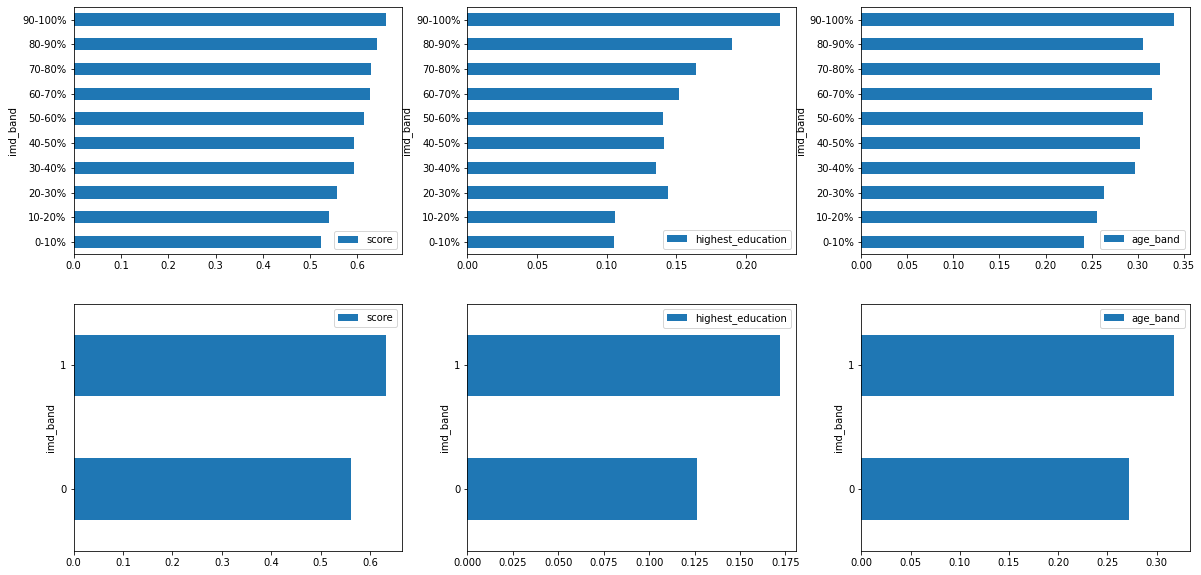

In [16]:
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

scaler = MinMaxScaler()

student_info.loc[student_info['imd_band'] == '10-20', 'imd_band'] = '10-20%'
unique_regions = student_info.groupby('imd_band').size().reset_index(name='counts')
student_avg_score = student_assessment[['id_student', 'score']].groupby('id_student').mean()
student_avg_score = pd.merge(student_info, student_avg_score, on='id_student', how='left')
student_avg_score['score'].fillna(0, inplace=True)
student_avg_score.dropna(subset = ['imd_band'], inplace=True)

student_avg_score.loc[(student_avg_score['highest_education'] == 'No Formal quals') | (student_avg_score['highest_education'] == 'A Level or Equivalent') | (student_avg_score['highest_education'] == 'Lower Than A Level'), 'highest_education'] = 0
student_avg_score.loc[(student_avg_score['highest_education'] == 'HE Qualification') | (student_avg_score['highest_education'] == 'Post Graduate Qualification') , 'highest_education'] = 1
student_avg_score['highest_education'] = pd.to_numeric(student_avg_score['highest_education'])

student_avg_score.loc[(student_avg_score['age_band'] == '0-35'), 'age_band'] = 0
student_avg_score.loc[(student_avg_score['age_band'] == '55<=') | (student_avg_score['age_band'] == '35-55'), 'age_band'] = 1
student_avg_score['age_band'] = pd.to_numeric(student_avg_score['age_band'])

student_avg_score_scaled = scaler.fit_transform(student_avg_score[['score', 'highest_education', 'age_band']])
student_avg_score['score'] = student_avg_score_scaled[:,0]

imd_avg_score = student_avg_score[['imd_band', 'score']].groupby('imd_band', as_index=False).mean()
imd_avg_edu = student_avg_score[['imd_band', 'highest_education']].groupby('imd_band', as_index=False).mean()
imd_avg_age = student_avg_score[['imd_band', 'age_band']].groupby('imd_band', as_index=False).mean()

imd_avg_score.plot(x='imd_band', y='score', ax=axs[0, 0], kind='barh')
imd_avg_edu.plot(x='imd_band', y='highest_education', ax=axs[0, 1], kind='barh')
imd_avg_age.plot(x='imd_band', y='age_band', ax=axs[0, 2], kind='barh')

student_avg_score.loc[(student_avg_score['imd_band'] == '0-10%') |
                     (student_avg_score['imd_band'] == '10-20%') |
                     (student_avg_score['imd_band'] == '20-30%') |
                     (student_avg_score['imd_band'] == '30-40%') |
                     (student_avg_score['imd_band'] == '40-50%'), 'imd_band'] = 0

student_avg_score.loc[(student_avg_score['imd_band'] == '50-60%') |
                     (student_avg_score['imd_band'] == '60-70%') |
                     (student_avg_score['imd_band'] == '70-80%') |
                     (student_avg_score['imd_band'] == '80-90%') |
                     (student_avg_score['imd_band'] == '90-100%'), 'imd_band'] = 1

student_avg_score['imd_band'] = pd.to_numeric(student_avg_score['imd_band'])


imd_avg_score = student_avg_score[['imd_band', 'score']].groupby('imd_band', as_index=False).mean()
imd_avg_edu = student_avg_score[['imd_band', 'highest_education']].groupby('imd_band', as_index=False).mean()
imd_avg_age = student_avg_score[['imd_band', 'age_band']].groupby('imd_band', as_index=False).mean()

imd_avg_score.plot(x='imd_band', y='score', ax=axs[1, 0], kind='barh')
imd_avg_edu.plot(x='imd_band', y='highest_education', ax=axs[1, 1], kind='barh')
imd_avg_age.plot(x='imd_band', y='age_band', ax=axs[1, 2], kind='barh')

Već kroz eksploratornu analizu podataka može se vidjeti blagi rast u prosječnom rezultatu u manje siromašnim regijama. Također, pokazuje se i da u pravilu siromašnije regije imaju mlađe stanovništvo te manje obrazovano stanovništvo. Naravno, to ne govori puno i potrebno je primijeniti model prije donošenja zaključaka..

Prije primjene samih modela varijabla <i>imd_band</i> će se pretvoriti u dihotomnu varijablu gdje će svi rasponi od uključivo "40-50%" biti označeni s 0, a svi rasponi iznad "40-50%" će biti označeni s 1. Tako se može reći da se varijabla sada dijeli na siromašnije i manje siromašne regije.

Model koji će se koristiti za klasifikaciju je <b><i>k-Nearest Neighbors</i></b>.

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV

X_train_imd, X_test_imd, y_train_imd, y_test_imd = train_test_split(student_avg_score[['score', 'age_band', 'highest_education']], student_avg_score['imd_band'], test_size=0.3, random_state=2)

#parameters = {"n_neighbors": range(1, 200)}
#knn_imd = GridSearchCV(KNeighborsClassifier(), parameters)
#knn_imd.fit(X_train_imd, y_train_imd)

print(f"Najbolji broj susjeda: 156") # Izračunato gornjim kodom

knn_imd = KNeighborsClassifier(n_neighbors=156)
knn_imd.fit(X_train_imd, y_train_imd)
result_test_imd = knn_imd.predict(X_test_imd)

print(f"Preciznost klasifikacije na skupu za provjeru: {accuracy_score(y_test_imd, result_test_imd)}")

Najbolji broj susjeda: 156
Preciznost klasifikacije na skupu za provjeru: 0.563790365272631


Iz dobivenih rezultata može se zaključiti da model kNN na temelju danih vrijednosti ne može sa sigurnošću odrediti kojem IMD rasponu pripada koji student. Preciznost na skupu za provjeru je svega ~56% što je marginalno bolje nego kad bi model nasumično pogađao.

Drugi model koji će se koristiti je <i><b>Random Forest</b></i> model. Razlika je u tome što će se ovaj put modelu predati gotovo sve varijable te će sam model odlučiti koje su najvažnije. Neke od izmjena su u varijabli 'gender' (M → 1, F → 0), u varijabli 'disability' (Y → 1, N → 0) i varijabli 'final_result' (Pass, Distinction → 1, Withdrawn, Fail → 0). Varijable 'code_module', 'code_presentation', 'id_student' i 'region' se neće koristiti.

In [18]:
student_avg_score_rf = student_avg_score.iloc[:,3:]
student_avg_score_rf = student_avg_score_rf.drop('region', axis=1)
student_avg_score_rf['disability'] = student_avg_score_rf['disability'].astype('category')
student_avg_score_rf['disability'] = student_avg_score_rf['disability'].cat.codes

student_avg_score_rf['gender'] = student_avg_score_rf['gender'].astype('category')
student_avg_score_rf['gender'] = student_avg_score_rf['gender'].cat.codes

student_avg_score_rf.loc[(student_avg_score_rf['final_result'] == 'Pass') | (student_avg_score_rf['final_result'] == 'Distinction'), 'final_result'] = 1
student_avg_score_rf.loc[(student_avg_score_rf['final_result'] == 'Fail') | (student_avg_score_rf['final_result'] == 'Withdrawn'), 'final_result'] = 0
student_avg_score_rf['final_result'] = student_avg_score_rf['final_result'].astype('category')
student_avg_score_rf['final_result'] = student_avg_score_rf['final_result'].cat.codes

student_avg_score_rf

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score
0,1,1,1,1,0,240,0,1,0.820000
1,0,1,0,1,0,60,0,1,0.664000
2,0,0,0,1,0,60,1,0,0.000000
3,0,0,1,1,0,60,0,1,0.760000
4,0,0,1,0,0,60,0,1,0.544000
...,...,...,...,...,...,...,...,...,...
32588,0,0,0,0,0,30,0,0,0.000000
32589,0,0,0,1,0,30,0,1,0.881111
32590,0,0,0,0,0,30,1,1,0.766667
32591,0,0,1,1,0,30,0,0,0.915000


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]

#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

'''Najbolji parametri: 
{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}'''


X_rf_imd = student_avg_score_rf[['gender', 'highest_education', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'score']]
y_rf_imd = student_avg_score_rf['imd_band']

X_train_rf_imd, X_test_rf_imd, y_train_rf_imd, y_test_rf_imd = train_test_split(X_rf_imd, y_rf_imd, test_size=0.3)

rfmodel = RandomForestClassifier(n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10, bootstrap=True)
rfmodel.fit(X_train_rf_imd,y_train_rf_imd)

result_rf_imd = rfmodel.predict(X_test_rf_imd)
print(f"Preciznost klasifikacije na skupu za provjeru: {accuracy_score(y_test_rf_imd, result_rf_imd)}")

feature_imp = pd.Series(rfmodel.feature_importances_,index=X_rf_imd.columns).sort_values(ascending=False)
print("\nNajbitnije značajke:")
print("-------------------")
print(feature_imp)

Preciznost klasifikacije na skupu za provjeru: 0.5763896241397565

Najbitnije značajke:
-------------------
score                   0.494167
studied_credits         0.146835
final_result            0.097085
gender                  0.058254
num_of_prev_attempts    0.055060
disability              0.052305
age_band                0.051926
highest_education       0.044368
dtype: float64


Kao što se može vidjeti ni model slučajnih šuma nije uspio uspješno klasificirati studente u njihove pripadajuće IMD raspone. Doduše, to je možda i bilo za očekivati. Glavni nedostatak IMD-a je da se mjeri drukčije u različitim regijama VB pa je i samim time i bilo za očekivati da modeli neće moći najbolje razlikovati studente. Bez obzira na to, i inače bi teško bilo klasificirati studente u IMD raspon jer regija iz koje je student nije nužno korelirana s njegovim uspjehom.

### Analiza korelacije varijabli s ishodom

Text(0.5, 1.0, "Pearson's correlation matrix for input variables")

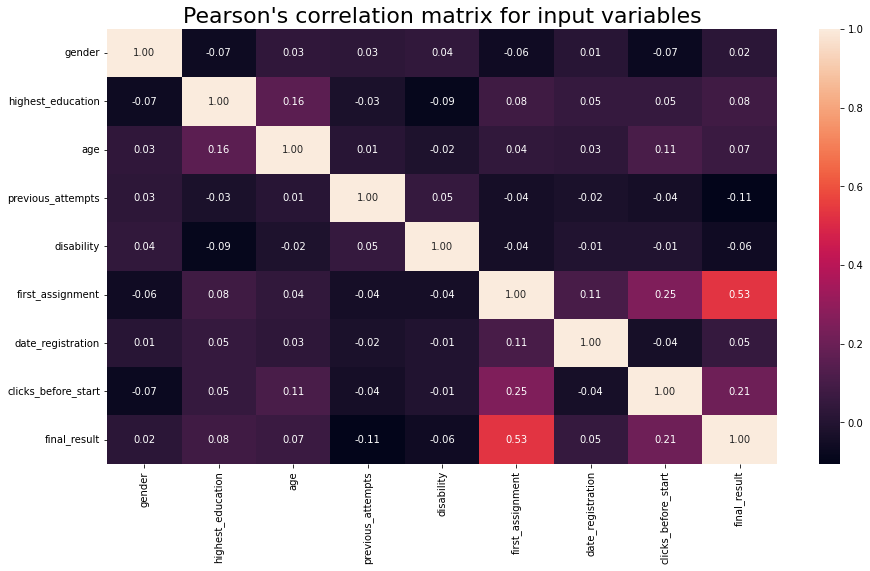

In [20]:
plt.figure(figsize=(15, 8))
corr = data.drop(columns=['id_student'], inplace=False).corr(method='pearson')
corr_heatmap = sns.heatmap(corr, annot=True, fmt='.2f')
corr_heatmap.set_title('Pearson\'s correlation matrix for input variables', fontdict={'fontsize': 22})

### GradientBoostingClassifier
#### Skaliranje podataka i podjela podataka na skup za treniranje i testiranje

In [21]:
data[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']].isnull().values.any()

False

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = data[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']]
# Podaci sa značajkama 'first_assignment' i 'clicks_before_start'
X_2 = data[['first_assignment', 'clicks_before_start']]

X_scaled = scaler.fit_transform(X)
X_2_scaled = scaler.fit_transform(X_2)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, data['final_result'].to_list(), test_size=0.3, random_state=2)
X_2_train_scaled, X_2_test_scaled, y_2_train_scaled, y_2_test_scaled = train_test_split(X_2_scaled, data['final_result'].to_list(), test_size=0.3, random_state=2)

### Potražnja najboljih hiperparametara učenja

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

gb_df = pd.DataFrame(columns=['max_depth', 'n_estimators', 'learning_rate', 'score'])

max_depth_list = [1, 2]
n_estimators_list = [20, 40, 50, 60, 70, 100, 200, 400, 1000, 2000, 5000]
learning_rate_list = [0.001, 0.005, 0.010, 0.050, 0.100, 0.150, 0.200, 0.250, 0.350, 0.500, 0.750, 1.000]

best_max_depth = max_depth_list[0]
best_n_estimators = n_estimators_list[0]
best_learning_rate =learning_rate_list[0]

i = 0

best_score = 0

with tqdm(total=len(max_depth_list) * len(n_estimators_list) * len(learning_rate_list)) as pbar:
    for max_depth in max_depth_list:
        for n_estimators in n_estimators_list:
            for learning_rate in learning_rate_list:
                reg = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
                reg.fit(X_train_scaled, y_train_scaled)
                score = reg.score(X_test_scaled, y_test_scaled)
                if score > best_score:
                    best_score = score
                    best_max_depth = max_depth
                    best_n_estimators = n_estimators
                    best_learning_rate = learning_rate
                pbar.update(1)
                gb_df.loc[i] = [max_depth, n_estimators, learning_rate, score]
                i += 1

100%|██████████| 264/264 [27:45<00:00,  6.31s/it]  


In [24]:
gb_df_2_ = pd.DataFrame(columns=['max_depth', 'n_estimators', 'learning_rate', 'score'])

max_depth_list = [1, 2]
n_estimators_list = [20, 40, 50, 60, 70, 100, 200, 400, 1000, 2000, 5000]
learning_rate_list = [0.001, 0.005, 0.010, 0.050, 0.100, 0.150, 0.200, 0.250, 0.350, 0.500, 0.750, 1.000]

best_score_2 = max_depth_list[0]
best_max_depth_2 = n_estimators_list[0]
best_n_estimators_2 =learning_rate_list[0]

i_2 = 0

best_score_2 = 0

with tqdm(total=len(max_depth_list) * len(n_estimators_list) * len(learning_rate_list)) as pbar:
    for max_depth in max_depth_list:
        for n_estimators in n_estimators_list:
            for learning_rate in learning_rate_list:
                reg = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
                reg.fit(X_2_train_scaled, y_2_train_scaled)
                score = reg.score(X_2_test_scaled, y_2_test_scaled)
                if score > best_score_2:
                    best_score_2 = score
                    best_max_depth_2 = max_depth
                    best_n_estimators_2 = n_estimators
                    best_learning_rate_2 = learning_rate
                pbar.update(1)
                gb_df_2_.loc[i_2] = [max_depth, n_estimators, learning_rate, score]
                i_2 += 1

100%|██████████| 264/264 [17:24<00:00,  3.96s/it]


### Heatmap pogreške za različite hiperparametara za sve značajke

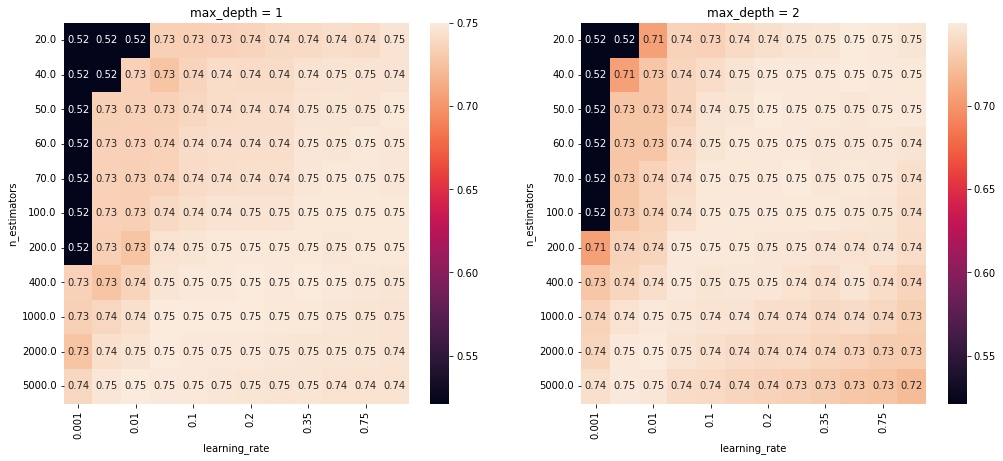

In [25]:
plt.subplot(1,2,1)

plt.title('max_depth = 1')
gb_df_1 = gb_df.copy()
gb_df_1 = gb_df_1[gb_df_1['max_depth'] == 1]
gb_df_1.drop_duplicates(['n_estimators','learning_rate'], inplace=True)
pivot = gb_df_1.pivot(index='n_estimators', columns='learning_rate', values='score')
ax = sns.heatmap(pivot,annot=True)

plt.subplot(1,2,2)

plt.title('max_depth = 2')
gb_df_2 = gb_df.copy()
gb_df_2 = gb_df_2[gb_df_2['max_depth'] == 2]
gb_df_2.drop_duplicates(['n_estimators','learning_rate'], inplace=True)
pivot = gb_df_2.pivot(index='n_estimators', columns='learning_rate', values='score')
ax = sns.heatmap(pivot,annot=True)

plt.gcf().set_size_inches(17, 7)

plt.show()

In [26]:
print('best_n_estimators = ' + str(best_n_estimators))
print('best_learning_rate = ' + str(best_learning_rate))
print('best_max_depth = ' + str(best_max_depth))
print('best_score = ' + str(best_score))

best_n_estimators = 1000
best_learning_rate = 0.15
best_max_depth = 1
best_score = 0.7500511352014727


### Heatmap pogreške za različite hiperparametara za značajke first_assignment' i 'clicks_before_start'

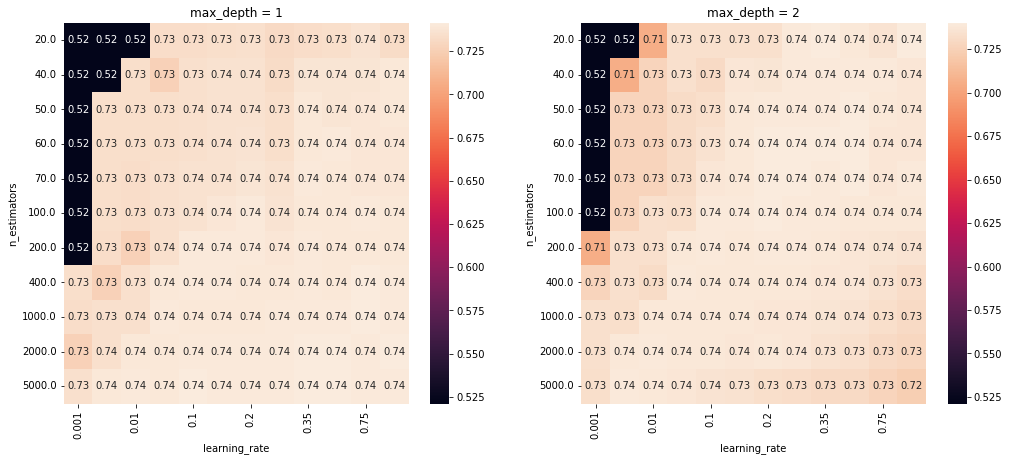

In [27]:
plt.subplot(1,2,1)

plt.title('max_depth = 1')
gb_df_1 = gb_df_2_.copy()
gb_df_1 = gb_df_1[gb_df_1['max_depth'] == 1]
gb_df_1.drop_duplicates(['n_estimators','learning_rate'], inplace=True)
pivot = gb_df_1.pivot(index='n_estimators', columns='learning_rate', values='score')
ax = sns.heatmap(pivot,annot=True)

plt.subplot(1,2,2)

plt.title('max_depth = 2')
gb_df_2 = gb_df_2_.copy()
gb_df_2 = gb_df_2[gb_df_2['max_depth'] == 2]
gb_df_2.drop_duplicates(['n_estimators','learning_rate'], inplace=True)
pivot = gb_df_2.pivot(index='n_estimators', columns='learning_rate', values='score')
ax = sns.heatmap(pivot,annot=True)

plt.gcf().set_size_inches(17, 7)

plt.show()

In [28]:
print('best_n_estimators = ' + str(best_n_estimators_2))
print('best_learning_rate = ' + str(best_learning_rate_2))
print('best_max_depth = ' + str(best_max_depth_2))
print('best_score = ' + str(best_score_2))

best_n_estimators = 5000
best_learning_rate = 0.35
best_max_depth = 1
best_score = 0.7413581509511148


### Rezultati
#### Sve značajke

In [29]:
gb_clf2 = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth)
gb_clf2.fit(X_train_scaled, y_train_scaled)
predictions = gb_clf2.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test_scaled, predictions))

print("Classification Report")
print(classification_report(y_test_scaled, predictions))

Confusion Matrix:
[[3366 1730]
 [ 714 3968]]
Classification Report
              precision    recall  f1-score   support

          -1       0.82      0.66      0.73      5096
           1       0.70      0.85      0.76      4682

    accuracy                           0.75      9778
   macro avg       0.76      0.75      0.75      9778
weighted avg       0.76      0.75      0.75      9778



 #### Značajke first_assignment i clicks_before_start

In [56]:
gb_clf2 = GradientBoostingClassifier(n_estimators=best_n_estimators_2, learning_rate=best_learning_rate_2, max_depth=best_max_depth_2)
gb_clf2.fit(X_2_train_scaled, y_2_train_scaled)
predictions = gb_clf2.predict(X_2_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_2_test_scaled, predictions))

print("Classification Report")
print(classification_report(y_2_test_scaled, predictions))

Confusion Matrix:
[[3236 1860]
 [ 669 4013]]
Classification Report
              precision    recall  f1-score   support

          -1       0.83      0.64      0.72      5096
           1       0.68      0.86      0.76      4682

    accuracy                           0.74      9778
   macro avg       0.76      0.75      0.74      9778
weighted avg       0.76      0.74      0.74      9778



### Eksperimentiranje s XGBoost Classifier

In [17]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled, y_train_scaled)
score = xgb_clf.score(X_test_scaled, y_test_scaled)

score

[17:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7354264675802823

### Modeli po predmetima

In [60]:
by_module_pom_1 = student_info.groupby(['code_module']).count().sort_values(['code_module'], ascending = [True]).reset_index()

by_module_pom_1 = by_module_pom_1.rename(columns = {"gender": "total"})
by_module_pom_1 = by_module_pom_1[['code_module', 'total']]

by_module_pom_2 = student_info[student_info['final_result'] == 'Pass'].groupby(['code_module']).count().sort_values(['code_module'], ascending = [True]).reset_index()

by_module_pom_2 = by_module_pom_2.rename(columns = {"gender": "pass_count"})
by_module_pom_2 = by_module_pom_2[['code_module', 'pass_count']]

by_module = pd.merge(by_module_pom_1, by_module_pom_2, on =['code_module'])

by_module["pass_rate[%]"] = round(((by_module["pass_count"] / by_module["total"]) * 100), 2)

by_module

,code_module,total,pass_count,pass_rate[%]
0,AAA,748,487,65.11
1,BBB,7909,3077,38.91
2,CCC,4434,1180,26.61
3,DDD,6272,2227,35.51
4,EEE,2934,1294,44.10
5,FFF,7762,2978,38.37
6,GGG,2534,1118,44.12


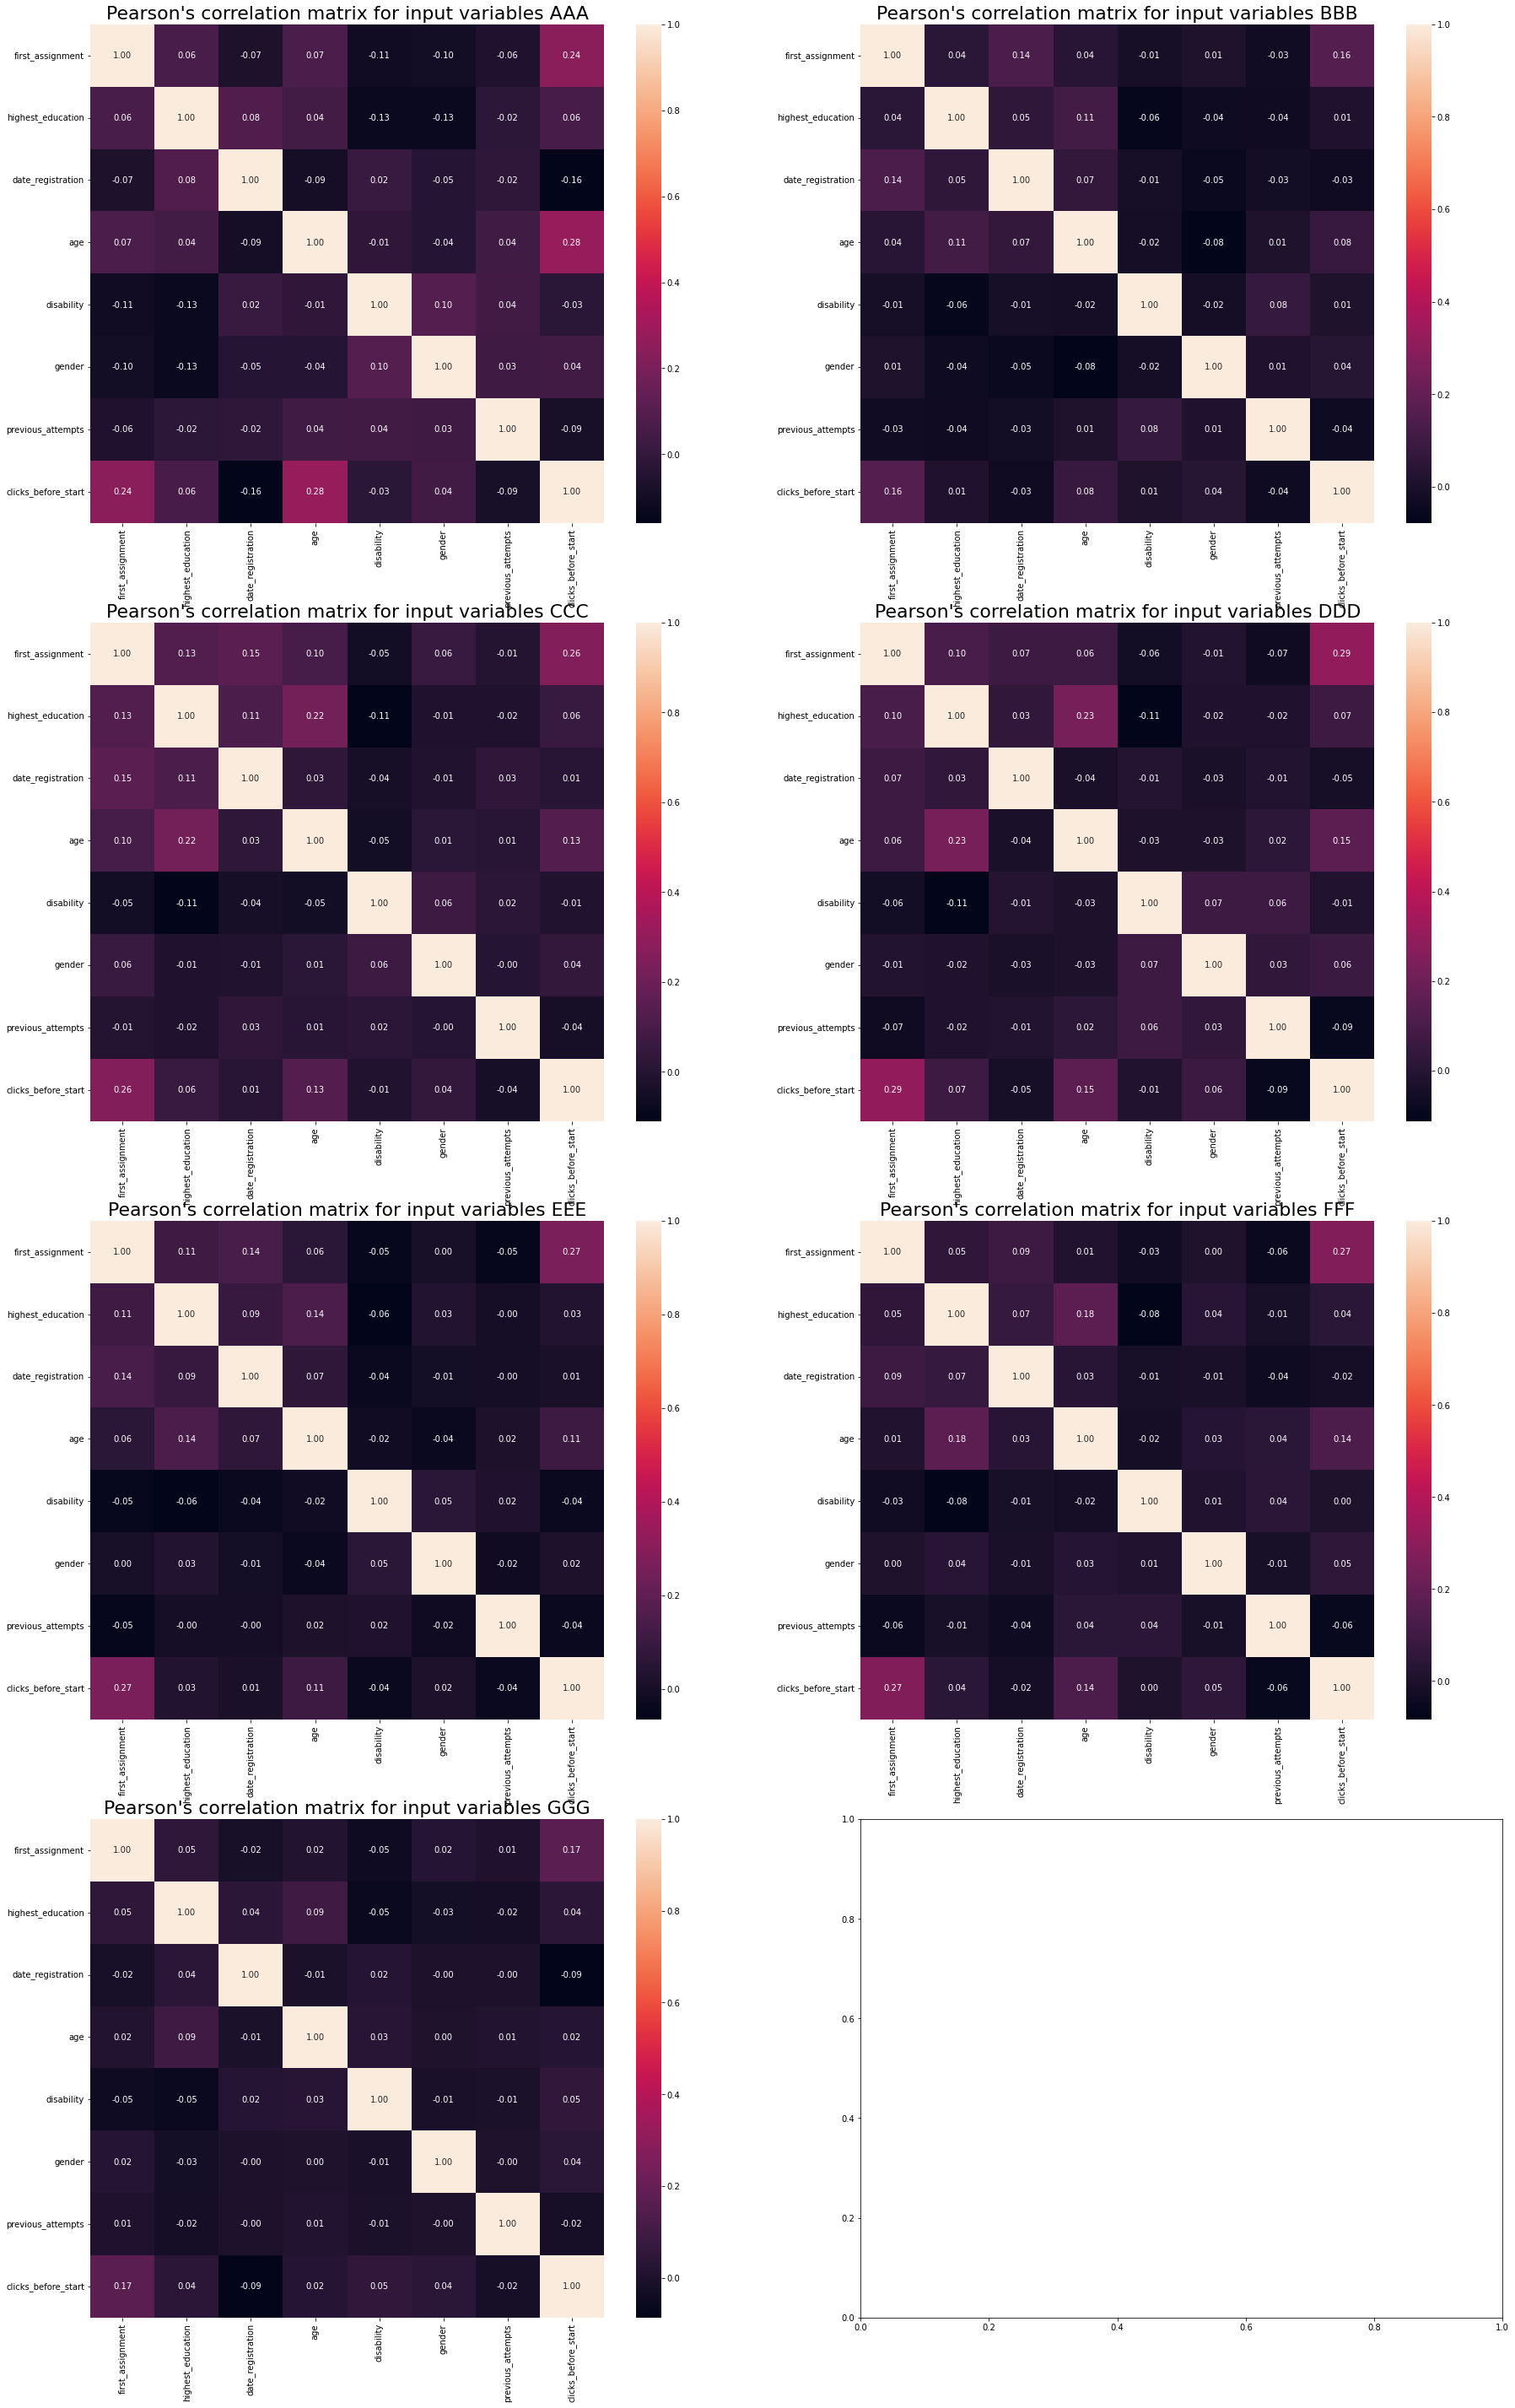

In [35]:
modules = ["AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"]
k = 1
plt.subplots(4, 2, figsize=(30, 50))
for module in modules:
    plt.subplot(4, 2, k)
    k += 1
    corr = data[data['code_module'] == module].drop(columns=['id_student', 'final_result'], inplace=False).corr(method='pearson')
    corr_heatmap = sns.heatmap(corr, annot=True, fmt='.2f')
    corr_heatmap.set_title(f"Pearson\'s correlation matrix for input variables {module}", fontdict={'fontsize': 22})

In [18]:
aaa = data[data['code_module'] == "AAA"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
bbb = data[data['code_module'] == "BBB"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
ccc = data[data['code_module'] == "CCC"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
ddd = data[data['code_module'] == "DDD"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
eee = data[data['code_module'] == "EEE"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
fff = data[data['code_module'] == "FFF"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]
ggg = data[data['code_module'] == "GGG"][['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration', 'final_result']]

In [19]:
from sklearn.model_selection import train_test_split

X_train_aaa, X_test_aaa, y_train_aaa, y_test_aaa = train_test_split(aaa[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], aaa['final_result'], test_size=0.3, random_state=2)

X_train_bbb, X_test_bbb, y_train_bbb, y_test_bbb = train_test_split(bbb[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], bbb['final_result'], test_size=0.3, random_state=2)

X_train_ccc, X_test_ccc, y_train_ccc, y_test_ccc = train_test_split(ccc[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], ccc['final_result'], test_size=0.3, random_state=2)

X_train_ddd, X_test_ddd, y_train_ddd, y_test_ddd = train_test_split(ddd[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], ddd['final_result'], test_size=0.3, random_state=2)

X_train_eee, X_test_eee, y_train_eee, y_test_eee = train_test_split(eee[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], eee['final_result'], test_size=0.3, random_state=2)

X_train_fff, X_test_fff, y_train_fff, y_test_fff = train_test_split(fff[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], fff['final_result'], test_size=0.3, random_state=2)

X_train_ggg, X_test_ggg, y_train_ggg, y_test_ggg = train_test_split(ggg[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']], ggg['final_result'], test_size=0.3, random_state=2)

datasets = {
    "aaa": [X_train_aaa, X_test_aaa, y_train_aaa, y_test_aaa],
    "bbb": [X_train_bbb, X_test_bbb, y_train_bbb, y_test_bbb],
    "ccc": [X_train_ccc, X_test_ccc, y_train_ccc, y_test_ccc],
    "ddd": [X_train_ddd, X_test_ddd, y_train_ddd, y_test_ddd],
    "eee": [X_train_eee, X_test_eee, y_train_eee, y_test_eee],
    "fff": [X_train_fff, X_test_fff, y_train_fff, y_test_fff],
    "ggg": [X_train_ggg, X_test_ggg, y_train_ggg, y_test_ggg]
}

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from bartpy.sklearnmodel import SklearnModel as BART

decision_trees, random_forests, barts = [], [], []

for key, value in datasets.items():
    decision_tree = DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)
    decision_tree.fit(value[0], value[2])
    decision_trees.append(decision_tree)

    random_forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', bootstrap=False, min_samples_split=10)
    random_forest.fit(value[0], value[2])
    random_forests.append(random_forest)

    bart = BART(n_burn=50, n_chains=2, n_samples=50, n_trees=10, alpha=0.9, beta=1.5)
    bart.fit(value[0], value[2])
    barts.append(bart)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

results = []
X_tests = [X_test_aaa, X_test_bbb, X_test_ccc, X_test_ddd, X_test_eee, X_test_fff, X_test_ggg]
y_tests = [y_test_aaa, y_test_bbb, y_test_ccc,  y_test_ddd,  y_test_eee, y_test_fff, y_test_ggg]
indexes = [i for i in range(7)]

idx = 0
for model in decision_trees + random_forests:
    idx = 0
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        results.append(score(y_pred=model.predict(X_tests[idx]), y_true=y_tests[idx]))
        idx += 1

for model in barts:
    idx = 0
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        results.append(score(y_pred=[1 if res >= 0 else -1 for res in model.predict(X_tests[idx])], y_true=y_tests[idx]))

split = np.array_split(results, 3)

multi = pd.MultiIndex.from_product(
    [['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], ['Precision', 'Recall', 'F1', 'Accuracy']],
    names=['Final result', 'Metric'])

results = pd.DataFrame(index=multi, columns=['Decision tree', 'Random forest', 'BART'],
                       data={'Decision tree': split[0], 'Random forest': split[1], 'BART': split[2]})
results

Decision tree  Random forest      BART
Final result Metric                                           
AAA          Precision       0.802632       0.836601  0.819588
             Recall          0.564545       0.589091  0.957831
             F1              0.578652       0.707948  0.883333
             Accuracy        0.668438       0.751328  0.813333
BBB          Precision       0.830986       0.823529  0.814070
             Recall          0.677273       0.788182  0.975904
             F1              0.604651       0.678392  0.887671
             Accuracy        0.658874       0.715728  0.817778
CCC          Precision       0.821705       0.836066  0.851240
             Recall          0.565455       0.660000  0.620482
             F1              0.607619       0.688868  0.717770
             Accuracy        0.674814       0.724761  0.640000
DDD          Precision       0.827869       0.822695  0.856061
             Recall          0.574545       0.609091  0.680723
             F1              0.634441       0.699219  0.758389
             Accuracy        0.695005       0.750266  0.680000
EEE          Precision       0.790000       0.838710  0.818182
             Recall          0.495455       0.502727  0.325301
             F1              0.679632       0.692784  0.465517
             Accuracy        0.696068       0.747609  0.448889
FFF          Precision       0.788991       0.849206  0.833333
             Recall          0.501818       0.520000  0.662651
             F1              0.613003       0.656282  0.738255
             Accuracy        0.678533       0.727418  0.653333
GGG          Precision       0.802817       0.802260  0.804878
             Recall          0.630000       0.806364  0.993976
             F1              0.583032       0.676320  0.889488
             Accuracy        0.665781       0.701382  0.817778